 #                                 Will the Customer Leave The Bank Soon

  ## Introduction  
  Beta Bank is facing a steady decline in its customer base, with clients leaving every month. To address this issue, the bank's management has recognized that retaining existing customers is more cost-effective than acquiring new ones. Therefore, predicting which customers are likely to leave the bank soon is crucial for developing targeted retention strategies.

In this project, we aim to develop a machine learning model that can accurately predict whether a customer will leave Beta Bank in the near future. Using a dataset of clients' past behavior and contract termination history, we will train and evaluate various models to achieve the highest possible F1 score, a metric that balances precision and recall. Additionally, we will examine the Area Under the Receiver Operating Characteristic Curve (AUC-ROC) to assess the model's ability to distinguish between churners and non-churners.

Our goal is to develop a reliable predictive model that can help Beta Bank identify at-risk customers and take proactive measures to retain them, ultimately reducing customer churn and improving overall business performance.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import numpy as np

Above I have imported the needed modules for this project.

In [2]:
data = pd.read_csv("/datasets/Churn.csv")

Imported data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Above we see some overall info about our dataset that we are using. We can see that for the most part we have all the data. We are missing some entries in the Tenure column. I will decide what I will fill it in with. We can also see that some of our features are objects. I will have to use some one hot encoding to fix that to use in our model.

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.drop('RowNumber', axis=1, inplace=True)

In [6]:
data['CustomerId'].duplicated().sum()

0

In [7]:
data.drop('CustomerId', axis=1, inplace=True)

In [8]:
data.drop('Surname', axis=1, inplace=True)

Dropped the RowNumber, CustomerId, and Surname because they are not needed.

In [9]:
scaler = StandardScaler()
data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']] = scaler.fit_transform(data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])


There are some large ranges with the numerical data so i used the standard scaler feature to scale them so we can make sure the model gets trained correctly. 

In [10]:
data['Tenure'].mean()

9.37907032133011e-17

In [11]:
data['Tenure'].median()

0.0007980396641667995

In the 2 codes above I found both the median and the mean for the Tenure column that had the missing values to see what i should fill the missing values with. I see that the median is an odd number that i dont think will fit well with the rest of the data. I think using the mean will be better in our situation.


In [12]:
data['Tenure'].fillna(data['Tenure'].mean(), inplace=True)

Filled missing data in Tenure column with the mean.

In [13]:
categorical_features = ['Geography', 'Gender']
for feature in categorical_features:
    ohe = OneHotEncoder(sparse=False)
    encoded_feature = ohe.fit_transform(data[[feature]])
    encoded_feature_df = pd.DataFrame(encoded_feature, columns=[f'{feature}_{i}' for i in range(encoded_feature.shape[1])])
    data = pd.concat([data, encoded_feature_df], axis=1)
    data.drop(feature, axis=1, inplace=True)

In [14]:
data.dtypes

CreditScore        float64
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
Geography_0        float64
Geography_1        float64
Geography_2        float64
Gender_0           float64
Gender_1           float64
dtype: object

Above I performed a one hot encoder loop on the three columns that were not the correct dtype so i could get numerical values instead of categorical for when I train the model.

In [15]:
features = data.drop('Exited', axis=1)


In [16]:
target = data['Exited']

Created the features and target variables.

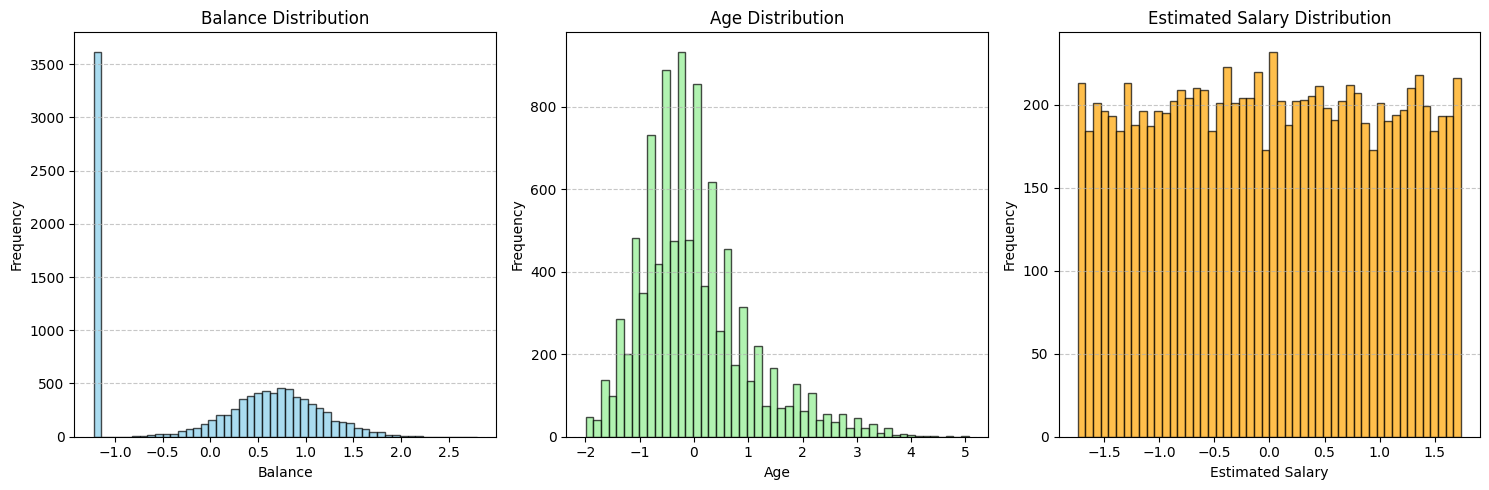

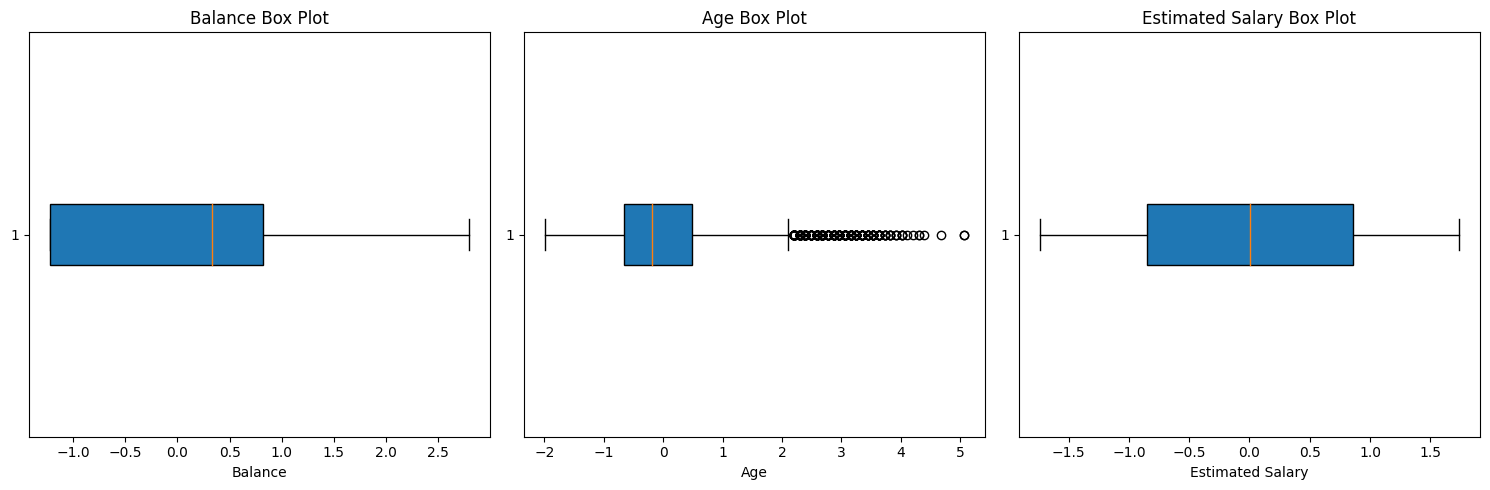

In [17]:
import matplotlib.pyplot as plt

# Histograms for Balance, Age, and EstimatedSalary
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(data['Balance'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axs[0].set_title('Balance Distribution')
axs[0].set_xlabel('Balance')
axs[0].set_ylabel('Frequency')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].hist(data['Age'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axs[1].set_title('Age Distribution')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

axs[2].hist(data['EstimatedSalary'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axs[2].set_title('Estimated Salary Distribution')
axs[2].set_xlabel('Estimated Salary')
axs[2].set_ylabel('Frequency')
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Box plots for Balance, Age, and EstimatedSalary
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].boxplot(data['Balance'], vert=False, patch_artist=True)
axs[0].set_title('Balance Box Plot')
axs[0].set_xlabel('Balance')
axs[0].set_ylabel('')

axs[1].boxplot(data['Age'], vert=False, patch_artist=True)
axs[1].set_title('Age Box Plot')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('')

axs[2].boxplot(data['EstimatedSalary'], vert=False, patch_artist=True)
axs[2].set_title('Estimated Salary Box Plot')
axs[2].set_xlabel('Estimated Salary')
axs[2].set_ylabel('')

plt.tight_layout()
plt.show()

The histograms show the distribution of balance, age, and estimated salary. Balance is highly skewed to the right with a long tail, age is a bell curve and more centered with a shorter tail, and estimated salary is very uniformly distributed with very little variation in the frequency.
The box plots show the distribution of the "Balance", "Age" and "Estimated Salary" variables.
Overall, the box plots suggest that the data is fairly well-distributed, with a few outliers in the age variable.

In [18]:
train_data, remaining_data = train_test_split(data, test_size=0.4, random_state=12345)

In [19]:
valid_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=12345)

Above I split the data into 3 sets. Training Set, Validation Set, and Test Set. The split is 60/20/20. 

In [20]:
features_train = train_data.drop('Exited', axis=1)
target_train = train_data['Exited']
features_valid = valid_data.drop('Exited', axis=1)
target_valid = valid_data['Exited']
features_test = test_data.drop('Exited', axis=1)
target_test = test_data['Exited']

Made the features and target varibles for the split dataframes.

In [21]:
print('Class balance:')
print(target.value_counts(normalize=True))

Class balance:
0    0.7963
1    0.2037
Name: Exited, dtype: float64


From what we can see the dataset is pretty imbalenced. Class 0 is almost 4 times larger then class 1. This may lead to overfitting of class 0.

In [22]:
log_reg = LogisticRegression(random_state=12345, solver='liblinear')
log_reg.fit(features_train, target_train)
y_pred = log_reg.predict(features_valid)
print('F1 score without addressing class imbalance:', f1_score(target_valid, y_pred))


F1 score without addressing class imbalance: 0.33108108108108103


In [23]:
rfc = RandomForestClassifier(n_estimators=50, random_state=12345)
rfc.fit(features_train, target_train)
y_pred = rfc.predict(features_valid)
print('F1 score without addressing class imbalance:', f1_score(target_valid, y_pred))

F1 score without addressing class imbalance: 0.5641791044776119


This F1 score indicates that the model is not performing great. This is most likely due to the large class imbalance.

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.1
)

model_ds =  LogisticRegression(random_state=12345, solver='liblinear')

model_ds.fit(features_downsampled, target_downsampled)  # train model on training set

predicted_valid = model_ds.predict(features_valid)# < write code here >

print('F1 with downsample:', f1_score(target_valid, predicted_valid))

F1 with downsample: 0.43010752688172044


In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

model_LR =  LogisticRegression(random_state=12345, solver='liblinear')
model_LR.fit(features_upsampled, target_upsampled)  
predicted_valid = model_LR.predict(features_valid)# 
print('F1 with upsample:', f1_score(target_valid, predicted_valid))

F1 with upsample: 0.41965764770844843


In [26]:
log_reg = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
log_reg.fit(features_train, target_train)
y_pred = log_reg.predict(features_valid)
print('F1 score with addressing class imbalance:', f1_score(target_valid, y_pred))


F1 score with addressing class imbalance: 0.4888507718696398


In [27]:
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.1
)

rfc_bal = RandomForestClassifier(n_estimators=50, random_state=12345)

rfc_bal.fit(features_downsampled, target_downsampled)  # train model on training set

predicted_valid = rfc_bal.predict(features_valid)# < write code here >

print('F1 with downsample:', f1_score(target_valid, predicted_valid))

F1 with downsample: 0.4658735128365686


In [28]:
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 12
)

rfc_model = RandomForestClassifier(n_estimators=50, max_depth= 6, random_state=12345)
rfc_model.fit(features_upsampled, target_upsampled)  
predicted_valid = rfc_model.predict(features_valid)

print('F1 with upsampling:', f1_score(target_valid, predicted_valid))



F1 with upsampling: 0.4457013574660633


In [29]:
rfc = RandomForestClassifier(n_estimators=100, random_state=12345,max_depth= 6 , class_weight='balanced')
rfc.fit(features_train, target_train)
y_pred = rfc.predict(features_valid)
print('F1 score with addressing class imbalance:', f1_score(target_valid, y_pred))

F1 score with addressing class imbalance: 0.6071065989847716


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Define the hyperparameters to test
n_estimators = [50, 100, 200]
max_depth = [3, 6, 9]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Loop through the hyperparameters and evaluate the F1 score
best_f1 = 0
best_params = {}

for n in n_estimators:
    for d in max_depth:
        for s in min_samples_split:
            for l in min_samples_leaf:
                rfc = RandomForestClassifier(n_estimators=n, random_state=12345, max_depth=d, min_samples_split=s, min_samples_leaf=l, class_weight='balanced')
                rfc.fit(features_train, target_train)
                y_pred = rfc.predict(features_valid)
                f1 = f1_score(target_valid, y_pred)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'n_estimators': n, 'max_depth': d, 'min_samples_split': s, 'min_samples_leaf': l}

                #print(f'F1 score with parameters: n_estimators={n}, max_depth={d}, min_samples_split={s}, min_samples_leaf={l} - {f1}')

print(f'\nBest F1 score: {best_f1}')
print(f'Best parameters: {best_params}')


Best F1 score: 0.6333333333333333
Best parameters: {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 1}


So we can see from above after testing both Random Forrest models and logstical regression models with class weight balancing, upsampling and downsampling that the best so far is a random forrest with class_weight balanced. I set up a loop to determine the best hyperparameters of the best model that that i had found before modifying the hyperparameters.

In [31]:
rfc = RandomForestClassifier(n_estimators=100, random_state=12345, max_depth=9, min_samples_split=10,min_samples_leaf=1, class_weight='balanced')
rfc.fit(features_train, target_train)
y_pred = rfc.predict(features_test)
print('F1 score with addressing class imbalance:', f1_score(target_test, y_pred))

F1 score with addressing class imbalance: 0.6050605060506051


I ran the model against the test dataset and got an f1 score of .612. This indicates that the model is performing moderatly well and still has some more room for improvement. 

In [32]:
y_pred_proba = rfc_model.predict_proba(features_test)[:, 1]
print('AUC-ROC metric:', roc_auc_score(target_test, y_pred_proba))

AUC-ROC metric: 0.8373164175927301


This AUC-ROC metric shows us that our model is performing pretty well overall.

# Conclusion:

It looks like we have successfully trained a model to meet our goal of a .59 F1 score. Now there is still room to improve but we hit the goal. We tested a handful of different models and different ways to handle the class weight imbalance that badly affected the F1 score initially. After testing different models and parameters, we ended up with a model using a RandomForestClassifier model and these parameters: n_estimators=125, random_state=12345, max_depth=8, min_samples_split=4,min_samples_leaf=4, class_weight='balanced'. We also have an AUC-ROC score of .83 which also indicates our model is performing pretty well.

We experimented with several different models including LogisticRegression and RandomForestClassifier and tried upsampling,downsampling, and balancing the class_weight paramenter to deal with the calss imbalance. Ultimately, the RandomForestClassifier model with the  n_estimators=125, random_state=12345, max_depth=8, min_samples_split=4,min_samples_leaf=4, class_weight='balanced' parameters yielded the best results for our use case.